In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [15]:
# Standardization formula: z = (x - mean) / standard_deviation

class Standardiser():
    def __init__(self) -> None:
        pass

    def fit(self, X):
        self.size = X.shape[1]
        self.mean = X.mean(axis=0)
        self.std = X.std(axis=0)
        return self     #returns self, which allows method chaining

    def transform(self,X):
        if X.shape[1] != self.size:
            raise Exception("Wrong array dimensions!")
        return (X-self.mean)/self.std


In [16]:
def shuffle_data(X, Y):
    data_num = np.arange(X.shape[0])
    np.random.shuffle(data_num)
    return X[data_num], Y[data_num]

def train_test_split(X, Y, test_size=0.5, shuffle=False):
    """
    Splits dataset into training and test sets.

    Parameters:
    ----------
    X : array-like
        Feature dataset.
    y : array-like
        Target values.
    test_size : float or int, default=0.5
        - If float (0 < test_size < 1), it represents the proportion of the dataset to include in the test split.
        - If int (1 <= test_size < len(y)), it represents the absolute number of test samples.
    shuffle : bool, default=True
        If True, shuffles data before splitting.

    Returns:
    -------
    X_train, X_test, y_train, y_test : array-like
        Split feature and target sets for training and testing."""

    if shuffle:
        X, Y = shuffle_data(X, Y)
    if test_size <1 :
        train_ratio = len(Y) - int(len(Y) *test_size)
        X_train, X_test = X[:train_ratio], X[train_ratio:]
        Y_train, Y_test = Y[:train_ratio], Y[train_ratio:]
        return X_train, X_test, Y_train, Y_test
    elif test_size in range(1,len(Y)):
        X_train, X_test = X[test_size:], X[:test_size]
        Y_train, Y_test = Y[test_size:], Y[:test_size]
        return X_train, X_test, Y_train, Y_test 

In [18]:
class MyLogisticRegression():
    def __init__(self, alpha, num_iter, mb_size=0.2, rs=None):
        self.alpha = alpha
        self.num_iter = num_iter
        self.mb = mb_size
        np.random.seed(rs)

    # Sigmoid function
    def _sigmoid_function(self, X):
        return 1 / (1 + np.exp(-X))

    # Compute hypothesis function (prediction) using sigmoid on linear combination of inputs
    def _h_theta(self, theta, X):
        return self._sigmoid_function(X @ theta)

    # Compute the logistic regression cost function for current predictions
    def _cost_function(self, X, y, theta):
        h = self._h_theta(theta, X)
        # Clip values of h to avoid log(0) errors
        h = np.clip(h, 1e-10, 1 - 1e-10)
        # Return the average cost for binary classification
        return -np.mean(y * np.log(h) + (1 - y) * np.log(1 - h))

    # Calculate the gradient of the cost function for parameter update
    def _calc_gradient(self, X, y, theta):
        return (X.T @ (y - self._h_theta(theta, X))) / len(y)

    def fit(self, X, y):
        self.dim = X.ndim
        self.classes = np.unique(y)  # Unique class labels for multi-class handling

        # Add a column of ones to X for the bias (intercept) term
        X = self._add_ones(X)

        # Initialize theta and cost matrices to store parameters and cost values for each class
        self.theta = np.zeros((len(self.classes), X.shape[1]))
        self.cost = np.zeros((len(self.classes), self.num_iter))

        # Determine minibatch size as a fraction of total data length
        l = len(X)
        self.mb_size = int(self.mb * l)

        # Train the model for each class (for multi-class logistic regression)
        for j, c in enumerate(self.classes):
            y_temp = np.where(y == c, 1, 0)  # Convert labels to binary for the current class
            # Perform gradient descent for specified number of iterations
            for i in range(self.num_iter):
                # Extract a random minibatch of data
                ind = np.random.permutation(l)[:self.mb_size]
                X_mb = X[ind, :]
                y_mb = y_temp[ind]

                # Update theta using the gradient descent step
                gradient = self._calc_gradient(X_mb, y_mb, self.theta[j])
                self.theta[j] += self.alpha * gradient

                # Calculate and store the cost for the current minibatch
                self.cost[j, i] = self._cost_function(X_mb, y_mb, self.theta[j])
        return self

    def predict(self, X):
        if X.ndim != self.dim:
            X = np.array([X])
        X = self._add_ones(X)
        # Predict the class label with the highest probability
        out = [self.classes[int(i)] for i in np.argmax(self._h_theta(self.theta.T, X), axis=1)]
        return np.array(out)

    def _add_ones(self, X):
        if type(X) != np.ndarray:
            X = np.array(X)
        return np.concatenate((np.ones((len(X), 1)), X), axis=1)


In [ ]:
def evaluate_model(Y_true, Y_pred, metric="class_accuracy", normalize=True):
    """
    Evaluate the model based on the specified metric.

    Parameters:
    - Y_true (array-like): True labels.
    - Y_pred (array-like): Predicted labels.
    - metric (str): The metric to use for evaluation. Options are "class_accuracy" and "mse".
    - normalize (bool): If True, returns accuracy as a fraction; otherwise, returns the count.

    Returns:
    - float: Calculated score based on the specified metric.
    """
    Y_true = np.ravel(Y_true)  # Flatten to 1D
    Y_pred = np.ravel(Y_pred)  # Flatten to 1D
    
    # Check if the shapes match
    if Y_true.shape != Y_pred.shape:
        raise ValueError("Y_true and Y_pred must have the same number of elements.")
    if metric == "class_accuracy":
        return np.mean(Y_true == Y_pred) if normalize else np.sum(Y_true == Y_pred)
    elif metric == "mse":
        return np.sqrt((np.square(Y_pred - Y_true)).mean())
    else:
        raise ValueError("Invalid metric. Choose either 'class_accuracy' or 'mse'.")

In [ ]:
def my_class_accuracy_score(Y_true, Y_pred, normalize=True):
    Y_true = np.ravel(Y_true)  # Flatten to 1D
    Y_pred = np.ravel(Y_pred)  # Flatten to 1D
    if Y_true.shape != Y_pred.shape:
        raise ValueError("Y_true and Y_pred must have the same number of elements.")
    return np.mean(Y_true == Y_pred) if normalize else np.sum(Y_true == Y_pred)

def cross_val_split(X, Y, num_folds):
    fold_size = len(X)//num_folds
    X_splits, Y_splits = [], []

    for i in range(num_folds):
        start_index = i * fold_size
        if i == num_folds-1:
            X_splits.append(X[start_index:])
            Y_splits.append(Y[start_index:])
        else:
            X_splits.append(X[start_index:start_index + fold_size])
            Y_splits.append(Y[start_index:start_index + fold_size])
    return X_splits, Y_splits


def cross_val_score(model, X, Y, num_folds=5, scoring='clsss_accuracy'):
    X_splits, Y_splits = cross_val_split(X, Y, num_folds)
    errors_train = []  
    errors_valid = []

    for i in range(num_folds):
        X_train_data = np.concatenate([fold for a, fold in enumerate(X_splits) if a != i])
        Y_train_data = np.concatenate([fold for a, fold in enumerate(Y_splits) if a != i])
        X_valid_data = X_splits[i]
        Y_valid_data = Y_splits[i]

        model.fit(X_train_data, Y_train_data)
        prediction_train = model.predict(X_train_data)
        prediction_valid = model.predict(X_valid_data)
        # Calculating mean square error
        train = evaluate_model(Y_train_data, prediction_train, metric=scoring)
        valid = evaluate_model(Y_valid_data, prediction_valid, metric=scoring)
        errors_train.append(train)
        errors_valid.append(valid) 
    return np.array(errors_train), np.array(errors_valid)


def validation_curve(model, X, Y, param_range, num_folds=5, scoring='clsss_accuracy'):
    range_error_train, range_error_valid = [], []
    model_use = model()
    for i in param_range:
        model_use.change_alfa(i)
        errors_train, errors_valid = cross_val_score(model_use, X, Y, num_folds, scoring)
        range_error_train.append(errors_train)
        range_error_valid.append(errors_valid)
    return range_error_train, range_error_valid

Test made functions:

In [19]:
#Read the data
dile_name = 'data-class.csv'
raw_data = pd.read_csv(dile_name, header=None).to_numpy()
X = raw_data[:,:5]
Y = raw_data[:,-1]

#Split data to train test datasets
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,0.2,shuffle=True)

#Standardisation of the data 
scaler = Standardiser().fit(X_train)
try:
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
except Exception as e:
  print(e)

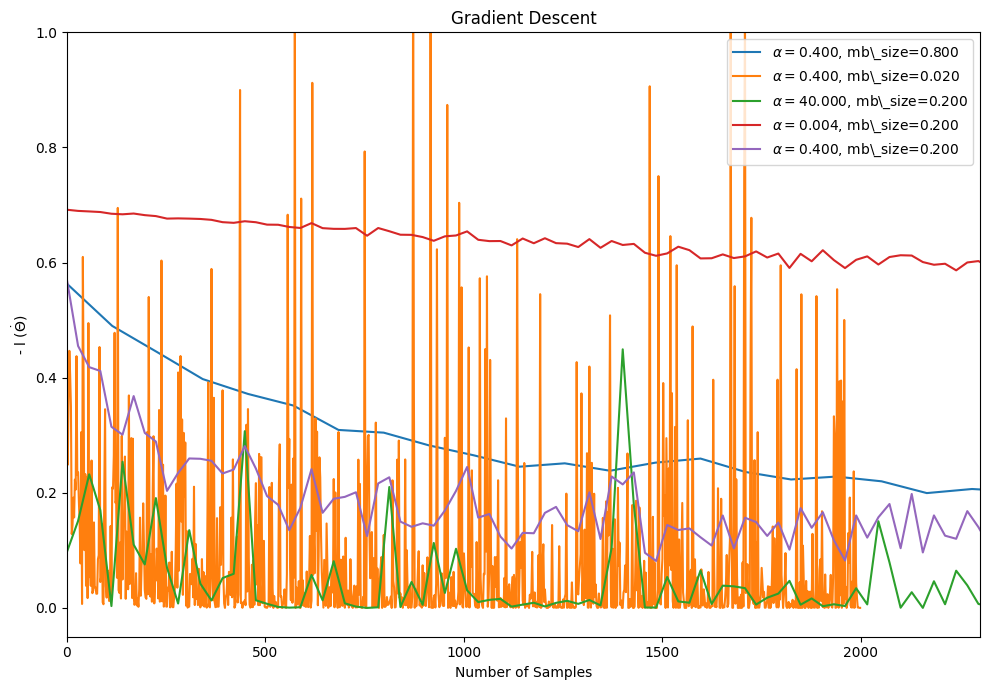

In [20]:
# Define optimal parameters
alpha_opt = 0.4
mb_opt = 0.2
parameters = [
    (alpha_opt, mb_opt * 4),
    (alpha_opt, mb_opt / 10),
    (alpha_opt * 100, mb_opt),
    (alpha_opt / 100, mb_opt),
    (alpha_opt, mb_opt)
]

# Set up the plot
plt.figure(figsize=(10, 7), dpi=100)

# Iterate over each parameter combination and plot results
for alpha, mb_size in parameters:
    # Train the model with the given parameters
    lr = MyLogisticRegression(alpha=alpha, num_iter=int(100 * mb_opt / mb_size), mb_size=mb_size, rs=8)
    lr.fit(X_train_scaled, Y_train)
    
    # Plot the cost over the number of samples
    num_samples = np.arange(len(lr.cost[1, :])) * lr.mb_size
    plt.plot(num_samples, lr.cost[1, :], label=fr"$\alpha={alpha:.3f}$, mb\_size={mb_size:.3f}")

# Customize plot appearance
plt.legend(loc='upper right')
plt.xlim(0, 2300)
plt.ylim(-0.05, 1)
plt.xlabel('Number of Samples')
plt.ylabel(r'- l ($\dot{\Theta}$)')
plt.title('Gradient Descent')

# Adjust layout and display
plt.tight_layout()
plt.show()


Optimal model performance:

In [21]:
lr = MyLogisticRegression(alpha = alpha_opt, num_iter=int(100*mb_opt/mb_opt), mb_size=mb_opt, rs=8)
lr.fit(X_train_scaled, Y_train)
try:
    # Training set performance
    Y_pred_train = lr.predict(X_train_scaled)
    accuracy_train =  my_class_accuracy_score(Y_train, Y_pred_train)
    print(f"Training set accuracy: {accuracy_train * 100:.2f}%")
except Exception as e:
    print(e)

# Test set performance
try:
    Y_pred_test = lr.predict(X_test_scaled)
    accuracy_test =  my_class_accuracy_score(Y_pred_test, Y_test)
    print(f"Test set ccuracy: {accuracy_test * 100:.2f}%")
except Exception as e:
    print(e)

Training set accuracy: 97.20%
Test set ccuracy: 97.14%


---
# Built-in functions results:

In [22]:
# # Import necessary libraries
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score, classification_report
# from sklearn.preprocessing import StandardScaler

# # Split the dataset into training and testing sets
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# scaler = StandardScaler().fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

# # Initialize and train the logistic regression model
# model = LogisticRegression(max_iter=200)  # Setting max_iter to ensure convergence
# model.fit(X_train, Y_train)

# # Make predictions on the test data
# Y_pred_train = model.predict(X_train)
# Y_pred_test = model.predict(X_test)

# # Evaluate the model
# accuracy_train = accuracy_score(Y_train, Y_pred_train)
# accuracy_test = accuracy_score(Y_test, Y_pred_test)
# report = classification_report(Y_test, Y_pred_test)

# print(f"Built-in model accuracy on train set: {accuracy_train * 100:.2f}%")
# print(f"Built-in model accuracy on test set: {accuracy_test * 100:.2f}%")
# print("\nClassification Report:\n", report)


In [23]:
# # Koeficijenti
# print('Lasso koeficijenti')
# print(model.coef_)
